# Customer Churn Prediction with PyTorch


In [97]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torch.nn import functional as F
from torch.autograd import Variable
import torch.optim as optim
from sklearn.datasets import fetch_california_housing
import pandas as pd
import matplotlib.pyplot as plt

## 1. Data Loading and Preprocessing


### 1.1 Load the Customer Churn Dataset

In [98]:
customer_churn_data = pd.read_csv('Churn_Modelling.csv')

### 1.2 Data Exploration

In [99]:
customer_churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [100]:
customer_churn_data.isnull().sum()

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


In [101]:
customer_churn_data['Exited'].value_counts()

,count
Exited,
0,7963
1,2037


In [102]:
customer_churn_data['Geography'].value_counts()

,count
Geography,
France,5014
Germany,2509
Spain,2477


In [103]:
customer_churn_data['Gender'].value_counts()

,count
Gender,
Male,5457
Female,4543


In [104]:
customer_churn_data = pd.get_dummies(customer_churn_data, columns= ['Geography', 'Gender'], drop_first=True)

### 1.3 Data Splitting and Scaling


In [105]:
X = customer_churn_data.drop(['RowNumber','CustomerId', 'Surname', 'Exited'], axis=1)
y = customer_churn_data['Exited']

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Initial split: Train+Validation and Test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: Train and Validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [107]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


## 2. Model Building


### 2.1 Define the Linear Classification Model

In [108]:
class Classification_Model(nn.Module):
    def __init__(self, X_features, output_dim):
        super(Classification_Model, self).__init__()
        self.weights_of_hidden_layer1 = nn.Parameter(torch.tensor(torch.rand(X_features, 16), requires_grad=True))
        self.bias_of_hidden_layer1 = nn.Parameter(torch.tensor(torch.rand(16), requires_grad=True))

        self.weights_of_hidden_layer2 = nn.Parameter(torch.tensor(torch.rand(16, 8), requires_grad=True))
        self.bias_of_hidden_layer2 = nn.Parameter(torch.tensor(torch.rand(8), requires_grad=True))

        self.weights_of_output_layer = nn.Parameter(torch.tensor(torch.rand(8, output_dim), requires_grad=True))
        self.bias_of_output_layer = nn.Parameter(torch.tensor(torch.rand(output_dim), requires_grad=True))

    def forward(self, x):
        hidden_layer1_input = torch.matmul(x, self.weights_of_hidden_layer1) + self.bias_of_hidden_layer1
        hidden_layer1_output = F.sigmoid(hidden_layer1_input)

        hidden_layer2_input = torch.matmul(hidden_layer1_output, self.weights_of_hidden_layer2) + self.bias_of_hidden_layer2
        hidden_layer2_output = F.relu(hidden_layer2_input)

        output_layer_input = torch.matmul(hidden_layer2_output, self.weights_of_output_layer) + self.bias_of_output_layer
        output_layer_output = torch.sigmoid(output_layer_input)

        return output_layer_output


## 3. Model Training

### 3.1 Define the Training Function

In [109]:
def train_model(model, train_data, val_data, n_epoch, training_batch_size, val_batch_size, loss_fn, optimizer):
        # init training data loader
        train_loader = DataLoader(dataset=train_data, batch_size=training_batch_size, shuffle=True)
        val_loader = DataLoader(dataset=val_data, batch_size=val_batch_size, shuffle=False)
        # Training loop
        train_losses = []
        val_losses = []

        for epoch in range(n_epoch):
            total_train_epoch_loss = 0
            total_val_epoch_loss = 0
            for x_batch, y_batch in train_loader:  # Process mini-batches
                model.train()

                # Forward pass
                yhat = model(x_batch)
                y_batch = y_batch.unsqueeze(1)
                loss = loss_fn(yhat, y_batch)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_train_epoch_loss += loss.item()

            avg_train_loss = total_train_epoch_loss / len(train_loader)
            # Store train loss
            train_losses.append(loss.item())
            print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}", end = '')

            with torch.no_grad():
                for X_val, y_val in val_loader:
                    model.eval()
                    yhat = model(X_val)
                    y_val = y_val.unsqueeze(1)
                    val_loss = loss_fn(yhat, y_val)
                    total_val_epoch_loss += val_loss.item()

            avg_val_loss = total_val_epoch_loss / len(val_loader)
            # Store train loss
            val_losses.append(val_loss.item())
            print(f"    Validation Loss: {avg_val_loss:.4f}")

        return train_losses, val_losses

### 3.2 Create Datasets and Train the Model

In [110]:
def get_dataset(X, y):
    dataset = TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y.values).float())
    return dataset

In [111]:
train_data = get_dataset(X_train, y_train)
val_data = get_dataset(X_val, y_val)
test_data = get_dataset(X_test, y_test)

In [112]:
torch.manual_seed(42)

In [113]:
model1 = Classification_Model(X_train.shape[1], 1);
optimizer = optim.Adam(model1.parameters(), lr=0.01)
loss_fn = nn.BCELoss()
train_losses_of_model1, val_losses_of_model1 = train_model(model1, train_data, val_data, n_epoch=30, training_batch_size=int(len(X_train)/10), val_batch_size=int(len(X_train)/10), loss_fn=loss_fn, optimizer=optimizer)

<ipython-input-108-5fddaaa0e640>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights_of_hidden_layer1 = nn.Parameter(torch.tensor(torch.rand(X_features, 16), requires_grad=True))
<ipython-input-108-5fddaaa0e640>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bias_of_hidden_layer1 = nn.Parameter(torch.tensor(torch.rand(16), requires_grad=True))
<ipython-input-108-5fddaaa0e640>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights_of_hidden_layer2 = nn.Parameter(torch.tensor(torch.rand(16, 8), requires_grad=True))
<

Epoch 1, Train Loss: 17.3597    Validation Loss: 7.4479
Epoch 2, Train Loss: 3.4676    Validation Loss: 3.2198
Epoch 3, Train Loss: 1.1549    Validation Loss: 0.6045
Epoch 4, Train Loss: 0.9156    Validation Loss: 0.5867
Epoch 5, Train Loss: 0.7098    Validation Loss: 0.8895
Epoch 6, Train Loss: 0.6933    Validation Loss: 0.7513
Epoch 7, Train Loss: 0.6586    Validation Loss: 0.6322
Epoch 8, Train Loss: 0.6454    Validation Loss: 0.6840
Epoch 9, Train Loss: 0.6379    Validation Loss: 0.6620
Epoch 10, Train Loss: 0.6307    Validation Loss: 0.6669
Epoch 11, Train Loss: 0.6161    Validation Loss: 0.6411
Epoch 12, Train Loss: 0.6074    Validation Loss: 0.6207
Epoch 13, Train Loss: 0.6009    Validation Loss: 0.6090
Epoch 14, Train Loss: 0.6117    Validation Loss: 0.6335
Epoch 15, Train Loss: 0.5876    Validation Loss: 0.5605
Epoch 16, Train Loss: 0.6039    Validation Loss: 0.6134
Epoch 17, Train Loss: 0.5601    Validation Loss: 0.5494
Epoch 18, Train Loss: 0.5796    Validation Loss: 0.5789


## 4. Model Evaluation

### 4.1 Define the Evaluation Function

In [114]:
# Evaluation function
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
def evaluate_model(model, test_data):

    test_loader = DataLoader(dataset=test_data, batch_size=len(test_data), shuffle=False)
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze() # probabilities
            preds = (outputs > 0.5).int()    # Convert to {0,1}
            predictions.extend(preds.numpy())
            targets.extend(labels.numpy())

    print("\nClassification Report:\n", classification_report(targets, predictions))
    print("\n\nAccuracy:", accuracy_score(targets, predictions))

    cm = confusion_matrix(targets, predictions)

    return cm


### 4.2 Evaluate Model Performance


In [115]:
cm = evaluate_model(model1, test_data)



Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.73      0.82      1607
         1.0       0.41      0.76      0.53       393

    accuracy                           0.74      2000
   macro avg       0.67      0.75      0.68      2000
weighted avg       0.83      0.74      0.76      2000



Accuracy: 0.7395


### 4.3 Plot training vs. validation loss

In [116]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses, title="Training vs. Validation Loss" ):
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


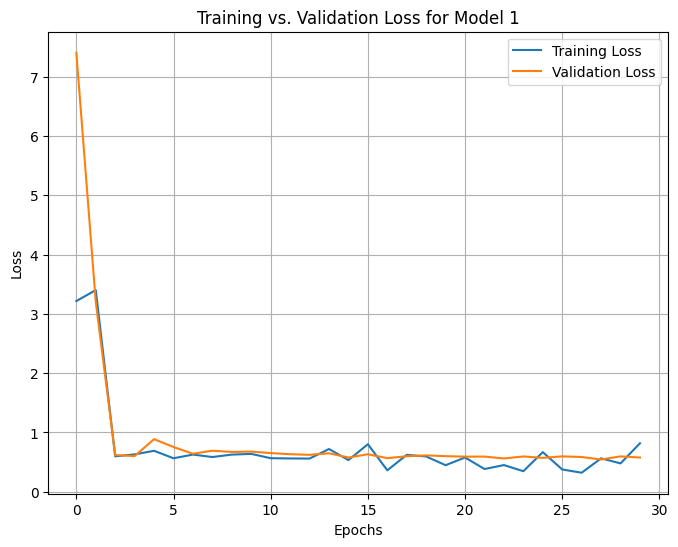

In [117]:
plot_loss(train_losses_of_model1, val_losses_of_model1, title='Training vs. Validation Loss for Model 1')

### 4.4 Plot Confusion Matrix

In [118]:
import seaborn as sns

def plot_confusion_matrix(confusion_matrix, title='Confusion Matrix'):

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


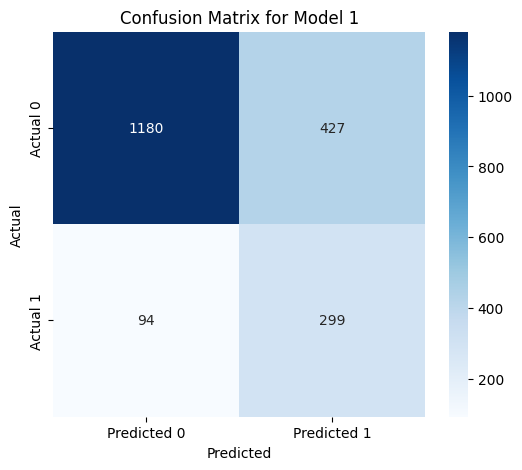

In [119]:
plot_confusion_matrix(cm, title='Confusion Matrix for Model 1')

## 5. Model Experimentation

### 5.1 Experiment with Different Hyperparameters

In [120]:
model2 = Classification_Model(X_train.shape[1], 1);
optimizer = optim.Adam(model2.parameters(), lr=0.01)
loss_fn = nn.BCELoss()
train_losses_of_model2, val_losses_of_model2 = train_model(model2, train_data, val_data, n_epoch=100, training_batch_size=int(len(X_train)/5), val_batch_size=int(len(X_train)/5), loss_fn=loss_fn, optimizer=optimizer)

<ipython-input-108-5fddaaa0e640>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights_of_hidden_layer1 = nn.Parameter(torch.tensor(torch.rand(X_features, 16), requires_grad=True))
<ipython-input-108-5fddaaa0e640>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bias_of_hidden_layer1 = nn.Parameter(torch.tensor(torch.rand(16), requires_grad=True))
<ipython-input-108-5fddaaa0e640>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights_of_hidden_layer2 = nn.Parameter(torch.tensor(torch.rand(16, 8), requires_grad=True))
<

Epoch 1, Train Loss: 27.5509    Validation Loss: 42.7537
Epoch 2, Train Loss: 24.0079    Validation Loss: 22.4013
Epoch 3, Train Loss: 7.1879    Validation Loss: 6.1450
Epoch 4, Train Loss: 3.0553    Validation Loss: 3.4614
Epoch 5, Train Loss: 1.4220    Validation Loss: 1.3981
Epoch 6, Train Loss: 0.7912    Validation Loss: 0.6255
Epoch 7, Train Loss: 0.8419    Validation Loss: 0.5932
Epoch 8, Train Loss: 0.7602    Validation Loss: 0.6688
Epoch 9, Train Loss: 0.6477    Validation Loss: 0.8505
Epoch 10, Train Loss: 0.7167    Validation Loss: 0.9454
Epoch 11, Train Loss: 0.7086    Validation Loss: 0.8368
Epoch 12, Train Loss: 0.6732    Validation Loss: 0.7191
Epoch 13, Train Loss: 0.6609    Validation Loss: 0.7022
Epoch 14, Train Loss: 0.6678    Validation Loss: 0.7063
Epoch 15, Train Loss: 0.6783    Validation Loss: 0.6871
Epoch 16, Train Loss: 0.6522    Validation Loss: 0.6605
Epoch 17, Train Loss: 0.6422    Validation Loss: 0.6429
Epoch 18, Train Loss: 0.6496    Validation Loss: 0.62

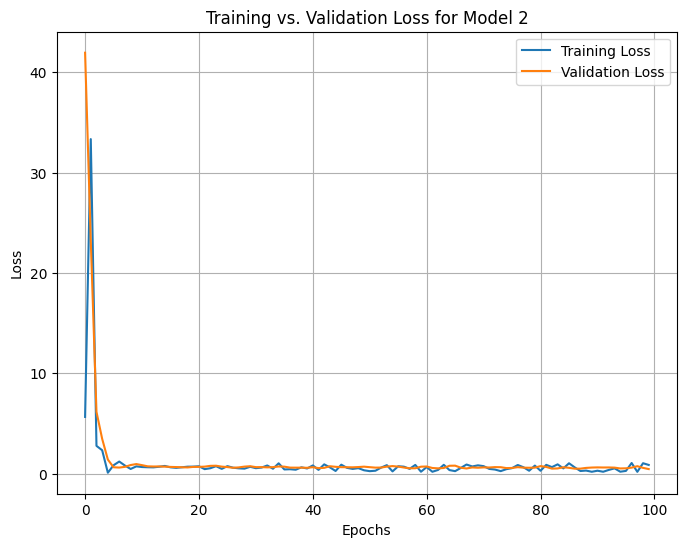

In [121]:
plot_loss(train_losses_of_model2, val_losses_of_model2, title='Training vs. Validation Loss for Model 2')

In [122]:
cm = evaluate_model(model2, test_data)


Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.91      0.90      1607
         1.0       0.58      0.52      0.55       393

    accuracy                           0.83      2000
   macro avg       0.73      0.71      0.72      2000
weighted avg       0.83      0.83      0.83      2000



Accuracy: 0.8325


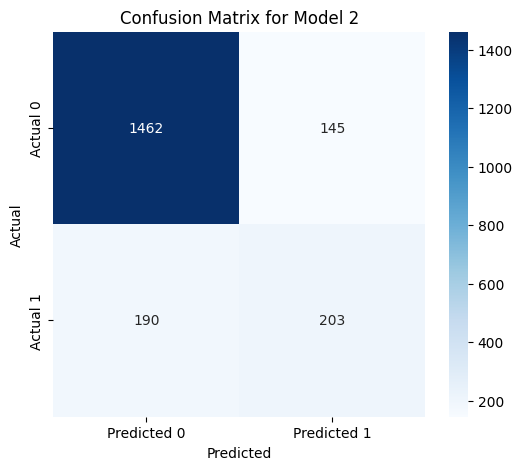

In [123]:
plot_confusion_matrix(cm, title='Confusion Matrix for Model 2')

In [124]:
model3 = Classification_Model(X_train.shape[1], 1);
optimizer = optim.Adam(model3.parameters(), lr=0.1)
loss_fn = nn.BCELoss()
train_losses_of_model3, val_losses_of_model3 = train_model(model3, train_data, val_data, n_epoch=100, training_batch_size=int(len(X_train)), val_batch_size=int(len(X_train)), loss_fn=loss_fn, optimizer=optimizer)

<ipython-input-108-5fddaaa0e640>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights_of_hidden_layer1 = nn.Parameter(torch.tensor(torch.rand(X_features, 16), requires_grad=True))
<ipython-input-108-5fddaaa0e640>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bias_of_hidden_layer1 = nn.Parameter(torch.tensor(torch.rand(16), requires_grad=True))
<ipython-input-108-5fddaaa0e640>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights_of_hidden_layer2 = nn.Parameter(torch.tensor(torch.rand(16, 8), requires_grad=True))
<

Epoch 1, Train Loss: 28.0757    Validation Loss: 11.3184
Epoch 2, Train Loss: 6.7571    Validation Loss: 3.5188
Epoch 3, Train Loss: 2.1776    Validation Loss: 0.5497
Epoch 4, Train Loss: 0.7779    Validation Loss: 0.8096
Epoch 5, Train Loss: 1.7977    Validation Loss: 0.8163
Epoch 6, Train Loss: 1.8063    Validation Loss: 0.6475
Epoch 7, Train Loss: 1.3250    Validation Loss: 0.5311
Epoch 8, Train Loss: 0.7955    Validation Loss: 0.7945
Epoch 9, Train Loss: 0.6779    Validation Loss: 1.2003
Epoch 10, Train Loss: 0.8492    Validation Loss: 1.4062
Epoch 11, Train Loss: 0.9543    Validation Loss: 1.4250
Epoch 12, Train Loss: 0.9637    Validation Loss: 1.3185
Epoch 13, Train Loss: 0.9072    Validation Loss: 1.1518
Epoch 14, Train Loss: 0.8225    Validation Loss: 0.9781
Epoch 15, Train Loss: 0.7419    Validation Loss: 0.8325
Epoch 16, Train Loss: 0.6856    Validation Loss: 0.7282
Epoch 17, Train Loss: 0.6590    Validation Loss: 0.6617
Epoch 18, Train Loss: 0.6552    Validation Loss: 0.6225

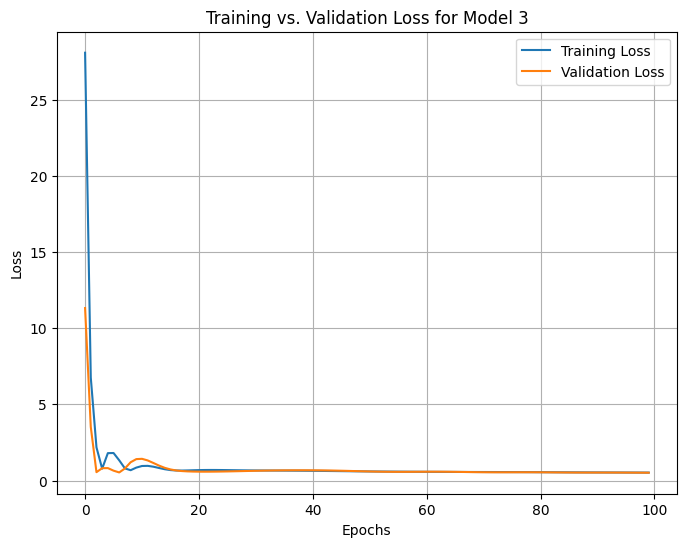

In [125]:
plot_loss(train_losses_of_model3, val_losses_of_model3, title='Training vs. Validation Loss for Model 3')

In [126]:
cm = evaluate_model(model3, test_data)


Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.73      0.82      1607
         1.0       0.41      0.76      0.53       393

    accuracy                           0.74      2000
   macro avg       0.67      0.75      0.68      2000
weighted avg       0.83      0.74      0.76      2000



Accuracy: 0.74


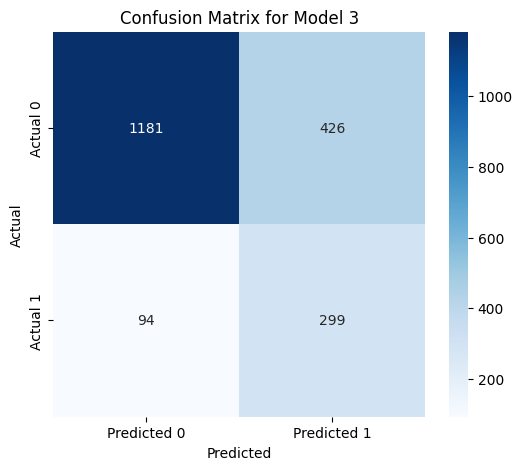

In [127]:
plot_confusion_matrix(cm, title='Confusion Matrix for Model 3')